## Лабораторная работа 2 
# "Выявление корреляций в выборке"

В этой работе рассматриваются данные о клиентах банка. В них указаны возраст клиентов, пол, образование, доход и есть целевая переменная - вернул ли клиент кредит.
На основе этих данных мы выясним какие из показателей влияют на вероятность того, что клиент не вернет кредит
Для начала зарузим библиотеки, необходимые в работе.
Обратите особое внимание на библиотеку skipy.stats. Она нужна для работы с распределениями

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats # в этой библиотеке хранятся функции для работы с распределениями
import scipy
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from numpy import *

In [2]:
#считаем данные и посмотрим на них
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
#EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) 
#MARRIAGE: Marital status (1=married, 2=single, 3=others)
#PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 9 - max)

In [4]:
#посмотрим на объем выборки в целом
data.shape

(30000, 25)

In [5]:
#посмотрим на объем выборки по отданным и не отданным кредитам
data.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

Явно выборки по признаку default не сбалансированы

In [6]:
# Посмотрим, есть ли пустые, или аномальные значения 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


In [7]:
data[['SEX', 'EDUCATION', 'MARRIAGE']].describe()

,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867
std,0.489129,0.790349,0.521970
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


In [8]:
# Отсутствующих данных нет
# В EDUCATION категории 5 и 6 не имею названия, категория 0 не описана.
# В MARRIAGE категория 0 не задокументирована

## Проверка статистического различия между выборками на основе доверительных интервалов

Для проверки статистического различия между выборками часто применяют метод построения доверительных интервалов.

Выдвигается нулевая гипотеза о том, что медианы в выбоках равны. Если построенные доверительные интервалы не перескаются, то нулевая гипотеза отвергается

### Построение доверительного интервала для медианы

Медиана, в отличии от среднего значения на выборке, не является стадартным параметром и для расчета доверительного интервала для нее нельзя использовать стандартную формулу z-интервала или t-интервала.
Медиана - это квантиль распределения и чтобы считать для нее доверительный интервал, нужно знать само распределение в выборке.

Распределение  в выборке, как правило, не известно. Его нужно как-то оценить.
Для этого хорошо пригоден метод бутстрапа.

### Идея бутстрапа

Пусть есть выборка из 10 шаров. 5 из них синих, 3 красных и 2 желтых. Нам нужно сделать из этой выборки 20 новых того же объема.

Используем хитрость. Возьмем наугад шар из начальной выборки. Пусть это будет синий шар. Это уже первый элемент новой выборки. Вернем выбранный шар в начальную выборку.  Повторим процесс 10 раз. Получим 1 новую выборку.
Посчитаем в ней медиану. Опять также сделаем новую выборку и посчитаем в ней медиану. Повторим этот процесс 20 раз.
И вот итог - у нас есть 20 медиан и теперь можно посчитать доверительный интервал.

## Непараметрические критерии

Подробная теория по ним и применимость дана в лекции. Здесь кратко вспомним когда какой критерий используется и сведем все в таблицу

 Критерий | Одновыборочный | Двухвыборочный | Двухвыборочный (связанные выборки)  
  ------------- | -------------|
  **Знаков**  | $\times$ | | $\times$ 
  **Ранговый** | $\times$  | $\times$ | $\times$  
  **Перестановочный** | $\times$  | $\times$ | $\times$ 

Критерий знаков реализован в функции sign_test(data, 0.5), где первый параметр сама выборка, второй - константа, которой равно значение медианы в нулевой гипотезе

Критерий знаковых рангов реализован в функции stats.wilcoxon(data - m0), где data - выборка, m0 - значение медианы

Для перестановочного критерия готовой функции нет, но даю функцию permutation_test(sample1, sample2,max_permutations = None) которая его реализует. Здесь sample - выборка.

In [9]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [10]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [11]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [12]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

## Задание 1

Разделите выборку на 2 группы по признаку вернули кредит или нет.

In [13]:
# Ваш код здесь
data_rtd = data.loc[data['default'] == 0]
data_nrtd = data.loc[data['default'] == 1]

print("Full data \n", data.default.value_counts())
print(" ")
print("Returned \n", data_rtd.default.value_counts())
print(" ")
print("Not returned \n", data_nrtd.default.value_counts())

Full data 
 0    23364
1     6636
Name: default, dtype: int64
 
Returned 
 0    23364
Name: default, dtype: int64
 
Not returned 
 1    6636
Name: default, dtype: int64


Постройте распределения признака "лимитный кредит" в обеих группах

AxesSubplot(0.125,0.125;0.775x0.755)


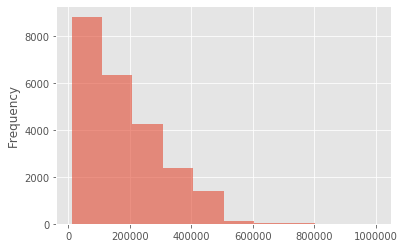

In [14]:
# Плотность распределения признака лимитный кредит в группе вернувших кредит
# Гистограмма:
print(data_rtd['LIMIT_BAL'].plot.hist(alpha=0.6))

AxesSubplot(0.125,0.125;0.775x0.755)


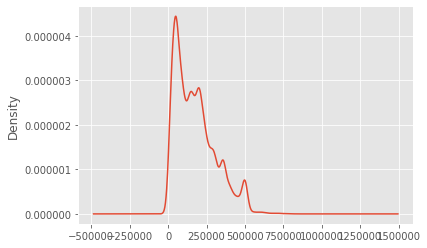

In [15]:
# График функции:
print(data_rtd['LIMIT_BAL'].plot.kde())

AxesSubplot(0.125,0.125;0.775x0.755)


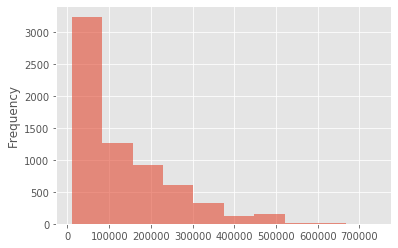

In [16]:
# Плотность распределения признака лимитный кредит в группе НЕвернувших кредит
# Гистограмма:
print(data_nrtd['LIMIT_BAL'].plot.hist(alpha=0.6))

AxesSubplot(0.125,0.125;0.775x0.755)


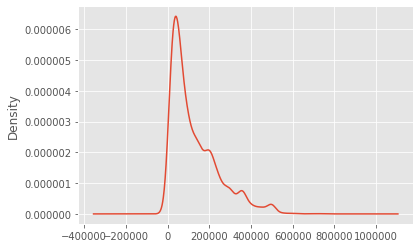

In [17]:
# График функции:
print(data_nrtd['LIMIT_BAL'].plot.kde())

Оцените распределения по внешнему виду

In [18]:
# Гистограммы с унимодальным распределением (1 ярко выраженный пик)
# Гистограммы с положительное ассиметрией 
# Похоже на логнормальное распределение

Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений размера лимитного кредита b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [19]:
#функция для бутстрапа
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [20]:
#функция для расчета доверительного интервала
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [21]:
# H0: медианы в выбоках равны
# H1: медианы в выбоках не равны
# Создаем массивы признаков
# Ваш код здесь
rtd_values1 = data_rtd.LIMIT_BAL.values
nrtd_values1 = data_nrtd.LIMIT_BAL.values
print(rtd_values1, rtd_values1.shape)
print(nrtd_values1, nrtd_values1.shape)

[ 90000  50000  50000 ... 100000 220000 150000] (23364,)
[ 20000 120000  70000 ...  30000  80000  50000] (6636,)


In [22]:
#фиксируем генератор случайных чисел
np.random.seed(0)
#создаем по 1000 выборок и считаем на них медиану
# используя map()
median_rtd1 = list(map(np.median, get_bootstrap_samples(rtd_values1, 1000)))
median_nrtd1 = list(map(np.median, get_bootstrap_samples(nrtd_values1, 1000)))
print ("Confidence interval, returned ",  stat_intervals(median_rtd1, 0.05))
print ("Confidence interval, not returned ",  stat_intervals(median_nrtd1, 0.05))

Confidence interval, returned  [150000. 150000.]
Confidence interval, not returned  [80000. 90000.]


In [23]:
# Ваши выводы здесь
# Интервалы не пересекаются. H0 отверагется, принимается H1. Сумма кредитов отличается у тех, кто вернул кредит и не вернул.
# Признак LIMIT_BAL влияет на целевую переменную default.

Здесь Ваши выводы о практической значимости

## Второе задание

Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Используйте stats.chi2_contingency() функцию для расчета кси-квадрат критерия

In [48]:
# Здесь Ваш код
# H0: Образование не влияет на то, вернет ли человек долг (То есть, EDUCATI-ON в data_rtd = EDUCATION в data_nrtd).
# H1: Образование влияет на то, вернет ли человек долг (То есть, EDUCATION в data_rtd != EDUCATION в data_nrtd).

def contingency_table(Col1, Col2):
    table = data.groupby([Col1, Col2]).size().unstack()
    is_nan = isnan(table)
    table[is_nan] = 0
    return table

table = contingency_table('default', 'EDUCATION')
print(table)

stat, p, dof, expected = chi2_contingency(table)
print(stat, p)

EDUCATION     0       1        2       3      4      5     6
default                                                     
0          14.0  8549.0  10700.0  3680.0  116.0  262.0  43.0
1           0.0  2036.0   3330.0  1237.0    7.0   18.0   8.0
163.21655786997073 1.2332626245415605e-32


Постройте график, отражающий уровень образования и разницу в прогнозе по возврату кредита

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


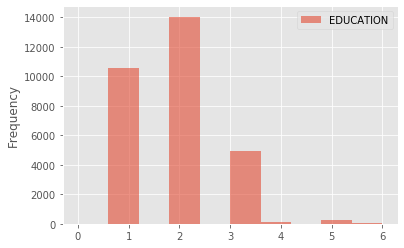

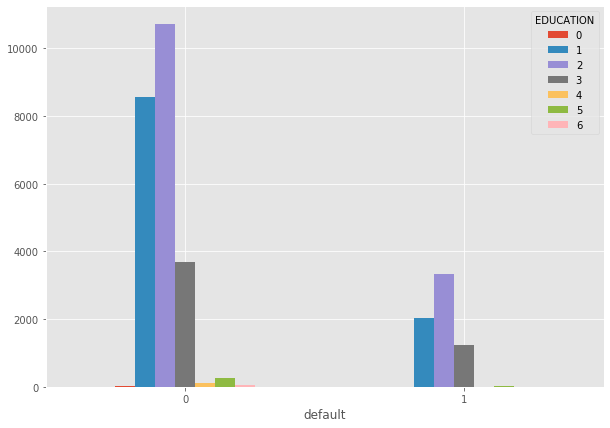

In [65]:
# Здесь Ваш код
# Посчитаем процент вернувших кредит в каждом уровне образования
print(data[['EDUCATION']].plot.hist(alpha=0.6))
print(table.plot.bar(rot=0, figsize=(10, 7)))

EDUCATION
0    0.000000
1    0.192348
2    0.237349
3    0.251576
4    0.056911
5    0.064286
6    0.156863
dtype: float64


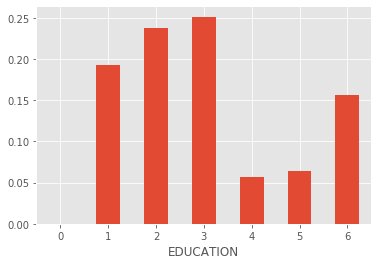

In [68]:
percentage = table.loc[1]/(table.loc[0] + table.loc[1]) 
print(percentage)
percentage.plot.bar(rot=0)

Здесь Ваши выводы

## Третье задание 

Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение

In [ ]:
# здесь Ваш код

Здесь Ваши выводы


Здесь выводы по всей лабораторной